In [118]:
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
import pandas as pd
import numpy as np
import os

%matplotlib inline

path = '/'.join(os.getcwd().split('/')[:-1])
print path

/Volumes/Dropbox/largetransfer/luc/carter


In [158]:
tci = pd.read_csv(path+'/data/model_data/tci_2_2.csv')
ppns = set(tci['ppn'])
ppns_num = set(tci['ppn'].apply(lambda x: x.replace('-','')))

## Foreclosure data

In [120]:
fc = pd.read_csv(path+'/data/clean_data/foreclosure_filings.csv', parse_dates=[2])

In [121]:
fc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45055 entries, 0 to 45054
Data columns (total 26 columns):
parcel            45055 non-null object
status            45055 non-null object
filedate          45055 non-null datetime64[ns]
defendant         45055 non-null object
caseno            45055 non-null object
parcel_address    44986 non-null object
dateid            45055 non-null object
FORE              45055 non-null int64
LATITUDE          45035 non-null float64
LONGITUDE         45035 non-null float64
zip_fore          43920 non-null float64
case_number       45055 non-null object
ctitle            45055 non-null object
cdesig            45055 non-null object
judge             45055 non-null object
magistrate        41211 non-null object
room              407 non-null object
n_action          408 non-null object
f_location        45053 non-null object
lstatus           45055 non-null object
lstatusdt         45055 non-null object
ldispos           45055 non-null object
ldisp

In [122]:
fc.head(2)

,parcel,status,filedate,defendant,caseno,parcel_address,dateid,FORE,LATITUDE,LONGITUDE,...,room,n_action,f_location,lstatus,lstatusdt,ldispos,ldisposdt,pamount,detaildt,plaintiff
0,107-16-046,Inactive,2006-10-03,"AHMAD HAKIM, ET AL",BR-06-000005,BLAINE AVENUE,03/21/2015,1,41.51486,-81.625548,...,NaN,NaN,DF-ROOM 45,INACTIVE,03/07/2007,DEFAULT,02/28/2007,$.00,12/24/2014,"JAMES ROKAKIS, AS TREASURER"
1,119-01-007,Inactive,2006-10-03,IDOLA SMITH AKA IDOLA BINION ET.AL.,BR-06-000018,1827 EAST 79TH STREET,03/21/2015,1,41.50848,-81.633084,...,NaN,NaN,DF-ROOM 45,INACTIVE,12/11/2007,DEFAULT,12/10/2007,$.00,03/21/2015,"JAMES ROKAKIS, AS TREASURER"


In [123]:
fc['pamount'] = fc['pamount'].apply(lambda x: float(x[1:].replace(',','')))

In [124]:
tem = fc.loc[fc.status=='Active',['parcel']]
tem['active_fc'] = 1
tem = tem.drop_duplicates()

In [125]:
tci = pd.merge(tci, tem, \
             how='left', left_on='ppn', right_on='parcel')

In [126]:
tem = fc.loc[fc.filedate>dt.datetime(2011, 3, 1),['parcel','pamount']].groupby('parcel').first()
tem.columns = ['foreclosure_flag']

tci = pd.merge(tci, tem, \
             how='left', left_on='ppn', right_index=True)

In [127]:
tci.loc[(tci.ppn.isin(set(fc[(fc.ldispos=='DIS. W/O PREJ')].parcel))),'fc_dis_w/o_prej'] = 1

In [128]:
tci.loc[(tci.ppn.isin(set(fc[(fc.ldispos=='NEWLY FILED')].parcel))),'fc_newly_filed'] = 1

In [129]:
tci.columns[100:]

Index([], dtype='object')

In [130]:
for dis in ['DEFAULT']:
    for i in xrange(2006,2016):
        tci.loc[(tci.ppn.isin(set(fc[(fc.ldispos==dis) & (fc.filedate.apply(lambda x: x.year) ==i)].parcel))),'fc_default'] = i
tci.loc[tci.fc_default.isnull(),'fc_default'] = 0

In [131]:
dis = 'DISP.OTHER'
for year in xrange(2006,2015):
    tci.loc[tci.ppn.isin(set(fc[(fc.ldispos==dis) & (fc.filedate.apply(lambda x: x.year) ==year)].parcel)),'fc_dispother'] = year
tci.loc[tci.fc_dispother.isnull(),'fc_dispother']= 0

In [132]:
for dis in set(fc.ldispos):
    a = tci[(tci.ppn.isin(set(fc[(fc.ldispos==dis) & (fc.filedate > dt.datetime(2014,3,1))].parcel))) & (tci.vacant>-1)]
    print(dis, len(a), sum(a.vacant))

('DIS. W/PREJ', 1, 0)
('DISP. TRANSCT', 0, 0)
('DISP.OTHER', 244, 144)
('NEWLY FILED', 283, 214)
('DEFAULT', 492, 174)
('UNAVAILABLE', 0, 0)
('DISPOSED', 0, 0)
('BANKRPT/C.O.A. STAY', 48, 6)
('DIS. W/O PREJ', 413, 62)
('SATISFIED', 0, 0)
('DISP.JURY TRIAL', 0, 0)
('MAGISTRATE', 1353, 312)
('ADR', 180, 8)
('DISP.COURT TRIAL', 0, 0)
('STAY', 1, 0)
('RET. STAY', 0, 0)


## Sheriff's auction

In [133]:
sa = pd.read_csv(path+'/data/clean_data/sheriff_auction.csv', parse_dates=[2], encoding="ISO-8859-1")

In [134]:
sa.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45843 entries, 0 to 45842
Data columns (total 25 columns):
parcel        45843 non-null object
address       45700 non-null object
salesdt       45843 non-null datetime64[ns]
saleno        45842 non-null float64
sold_amt      28609 non-null object
appraisal     37038 non-null object
minbid        37050 non-null object
scaseno       45843 non-null object
withdrawn     17813 non-null object
plaintiff     45831 non-null object
sdefend       45840 non-null object
purchaser     31260 non-null object
paddress      42891 non-null object
rparty        35478 non-null object
raddress      35478 non-null object
attorney      44680 non-null object
descript      40222 non-null object
location      23362 non-null object
defend_att    5857 non-null object
with          17813 non-null object
status        4508 non-null object
ssold         31381 non-null object
SHF           45843 non-null int64
LATITUDE      45831 non-null float64
LONGITUDE     45831 

In [135]:
sa['year'] = sa.salesdt.apply(lambda x: x.year)

In [136]:
for y in xrange(2000,2016):
    tem = pd.merge(tci, sa.loc[sa.year==y,['year','parcel']].groupby('parcel').count(), left_on='ppn',right_index=True,how='left')
    tem[tem.year>0].year = 1
    tem[tem.year<1].year = 0
    tem.year = tem.year.fillna(0)
    print y, sum(tem[(tem.vacant>-1) & (tem.year > 0)].vacant), sum(tem[tem.vacant>-1].year), sum(tem[(tem.vacant>-1) & (tem.year > 0)].vacant)/ sum(tem[tem.vacant>-1].year)

2000 149 922.0 0.161605206074
2001 155 1009.0 0.153617443013
2002 199 1307.0 0.152257077276
2003 290 1834.0 0.15812431843
2004 379 2105.0 0.180047505938
2005 585 3270.0 0.178899082569
2006 696 4373.0 0.159158472445
2007 952 5858.0 0.162512803004
2008 859 4603.0 0.18661742342
2009 468 3250.0 0.144
2010 304 2672.0 0.11377245509
2011 211 1837.0 0.114861186717
2012 278 2279.0 0.12198332602
2013 445 2486.0 0.179002413516
2014 674 2276.0 0.296133567663
2015 271 719.0 0.376912378303


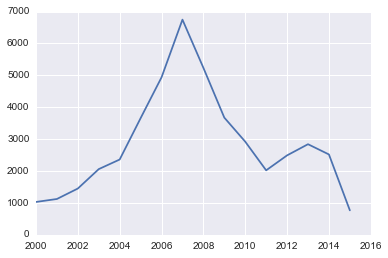

In [137]:
plt.plot(sa[['parcel','year']].groupby('year').count().index, sa[['parcel','year']].groupby('year').count().values);

In [138]:
def parse_amount(x):
    return float(str(x)[1:].replace(',',''))

In [139]:
sa.loc[sa.appraisal.notnull(), 'appraisal'] = sa.loc[sa.appraisal.notnull(), 'appraisal'].apply(parse_amount)

In [140]:
sa['ssold'] = sa.ssold.apply(lambda x: 1 if x=='Yes' else 0)

In [141]:
tem = sa.loc[sa.salesdt>dt.datetime(2013, 1, 1),['parcel','ssold']].groupby('parcel').sum()
tem.columns = ['auction_13']
tem.loc[tem['auction_13'].isnull(),'auction_13'] = 0
tci = pd.merge(tci, tem, \
              how='left', left_on='ppn', right_index=True)
tci.loc[tci['auction_13'].isnull(),'auction_13'] = 0
tci.loc[(tci.vacant>-1),['auction_13','vacant']].groupby('auction_13').agg([sum,len])

vacant        
              sum     len
auction_13               
0            8798  107559
1             882    3251
2              62     288
3              17      48
4               1       4

In [142]:
sum(tci.auction_13)

4419.0

In [143]:
tem = sa[['parcel','ssold']].groupby('parcel').sum()
tem.columns = ['auction_all']
tem.loc[tem['auction_all'].isnull(),'auction_all'] = 0
tci = pd.merge(tci, tem, \
              how='left', left_on='ppn', right_index=True)
tci.loc[tci['auction_all'].isnull(),'auction_all'] = 0

tci.loc[(tci.vacant>-1),['auction_all','vacant']].groupby('auction_all').agg([sum,len])

vacant       
               sum    len
auction_all              
0             5855  87980
1             3067  18863
2              703   3700
3              108    466
4               20    100
5                3     22
6                4     14
7                0      4
8                0      1

In [144]:
# tci[tci.auction_13.isnull()] = 0
# tci[tci.auction_13 > 0] = 1
# tci[tci.auction_all.isnull()] = 0
# tci[tci.auction_all > 0] = 1

## Tax bill

In [145]:
tb = pd.read_csv(path+'/data/clean_data/taxbill_dec14.csv', dtype=object)

In [146]:
tb.head()

,TAX_BILL_ID,TAX_YEAR,WHS_ID,PROPERTY_ID,PPN,PROPERTY_NUMBER,MACHINE_ID,EFFECTIVE_STATUS,VALUE_CHANGE_TIMESTAMP,PROPERTY_TYPE,...,LOCATION_UNIT_NUMBER,HOMESTEAD_ASSESSED_VALUE,SURPLUS_PAYMENT,OMITTED_TAX_PENALTY_1ST,OMITTED_TAX_PENALTY_2ND,AUDITOR_REFUND,TRASURER_REFUND,TIF_AMOUNT_1ST,TIF_AMOUNT_2ND,UPDATE_DATE
0,284393728,2014,4287556,603364178,00707138,007-07-138,NaN,NaN,NaN,800,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,12/09/2014
1,284393729,2014,4287558,103364182,00707140,007-07-140,NaN,NaN,NaN,800,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,12/09/2014
2,284393730,2014,4287559,403364185,00707141,007-07-141,NaN,NaN,NaN,800,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,12/09/2014
3,284393731,2014,4287560,703364188,00707142,007-07-142,NaN,NaN,NaN,800,...,NaN,NaN,5.23,NaN,NaN,NaN,NaN,0,0,12/09/2014
4,284393733,2014,4287562,403364194,00707144,007-07-144,NaN,NaN,NaN,800,...,NaN,8750,NaN,NaN,NaN,NaN,NaN,0,0,12/09/2014


In [147]:
tb = tb.fillna(0)

In [148]:
# plt.hist(t.loc[(t.vacant==0),'GRAND_TOTAL_BALANCE'].apply(float).values, bins = np.linspace(0,20000),alpha=0.5,normed=True);
# plt.hist(t.loc[(t.vacant==1),'GRAND_TOTAL_BALANCE'].apply(float).values, bins = np.linspace(0,20000),alpha=0.5,normed=True);

In [149]:
# t.loc[(t.vacant>-1), ['LENDER_PROCESS_TYPE','vacant']].groupby('LENDER_PROCESS_TYPE').agg([sum,len])

In [150]:
# t.loc[t.LENDER_PROCESS_TYPE==0,'LENDER_PROCESS_TYPE'] = 'None'

In [151]:
tci = pd.merge(tci, tb[['PROPERTY_NUMBER','LENDER_PROCESS_TYPE','GRAND_TOTAL_BALANCE']], left_on='ppn', right_on='PROPERTY_NUMBER',how='left')

In [152]:
tci.loc[tci.LENDER_PROCESS_TYPE==0,'LENDER_PROCESS_TYPE'] = 'None'

In [153]:
tci.shape

(122560, 85)

In [154]:
tci.to_csv(path+'/data/model_data/tci_2_3.csv',index=False)

In [155]:
tci.shape

(122560, 85)